In [ ]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-u3usonpk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-u3usonpk
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=16c6f044dd812fae277cb8cbcafba236b362245c5a3b3770c40123923b86da38
  Stored in directory: /tmp/pip-ephem-wheel-cache-3bw3hvi3/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


In [ ]:
import torch
import clip
from PIL import Image
import os
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import make_grid
import matplotlib
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 48.3MiB/s]


In [ ]:
clip_model.visual

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
data_dir = './data/cifar10'
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
random_seed = 42
torch.manual_seed(random_seed)
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, images, labels):
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, images, labels): 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.clip = clip_model.visual
        self.network = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10))
        
    def forward(self, xb):
        xb = self.clip(xb)
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (clip): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
 

In [ ]:
# test on one image
images_list = []

image, _ = dataset[100]
transform = T.ToPILImage()
image = transform(image)
image_input = preprocess(image).unsqueeze(0).to(device).squeeze()
images_list.append(np.asarray(image_input.cpu() if torch.cuda.is_available() else image_input))

image, _ = dataset[200]
transform = T.ToPILImage()
image = transform(image)
image_input = preprocess(image).unsqueeze(0).to(device).squeeze()
images_list.append(np.asarray(image_input.cpu() if torch.cuda.is_available() else image_input))

images_list = np.asarray(images_list)
images_list = torch.from_numpy(images_list)

print(images_list.shape)

images_list = images_list.to(device)
model = model.to(device)
if torch.cuda.is_available():
  model = model.type(torch.cuda.FloatTensor)
output = model(images_list)
output.shape

torch.Size([2, 3, 224, 224])


torch.Size([2, 10])

# in this part I want to check if clip parts parameters of model get updated or not

In [ ]:
model = Cifar10CnnModel()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Cifar10CnnModel(
  (clip): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
 

In [ ]:
from tqdm import tqdm
import copy

transform = T.ToPILImage()

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = list()
    for images, labels in tqdm(val_loader):
      new_images = []
      for i, image in enumerate(images):
        image_input = preprocess(transform(image)).unsqueeze(0).to(device)
        image_input = image_input.squeeze()
        new_images.append(np.asarray(image_input.cpu()))
      new_images = np.asarray(new_images)
      new_images = torch.from_numpy(new_images)
      new_images = new_images.to(device)
      labels = labels.to(device)
      outputs.append(model.validation_step(new_images, labels))
    return model.validation_epoch_end(outputs)

def check_parameters(before_model, after_model):
  params_before = before_model.state_dict()
  params_after = after_model.state_dict()
  total_number = 0
  equal_number = 0
  for key in params_before.keys():
    if key.startswith("clip"):
      this_layer_equal = (params_before[key] == params_after[key]).sum()
      this_layer_total = len(params_before[key])
      if this_layer_equal == this_layer_total:
        equal_number += 1
      total_number += 1
  print(total_number, equal_number)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    # Training Phase 
    model.train()
    for images, labels in tqdm(train_loader):
        new_images = []
        for i, image in enumerate(images):
          image_input = preprocess(transform(image)).unsqueeze(0).to(device)
          image_input = image_input.squeeze()
          new_images.append(np.asarray(image_input.cpu()))
        new_images = np.asarray(new_images)
        new_images = torch.from_numpy(new_images)
        before_model = copy.deepcopy(model)

        new_images = new_images.to(device)
        labels = labels.to(device)

        loss = model.training_step(new_images, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        after_model = copy.deepcopy(model)
        check_parameters(before_model, after_model)
        break

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/352 [00:01<?, ?it/s]

152 0


<font color="red">So we can understand that by default, clip parts parameters get updated, so we shuould freeze them</font>

# without freezing fine tune

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for images, labels in tqdm(train_loader):
            new_images = []
            for i, image in enumerate(images):
              image_input = preprocess(transform(image)).unsqueeze(0).to(device)
              image_input = image_input.squeeze()
              new_images.append(np.asarray(image_input.cpu()))
            new_images = np.asarray(new_images)
            new_images = torch.from_numpy(new_images)

            new_images = new_images.to(device)
            loss = model.training_step(new_images, labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = Cifar10CnnModel()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Cifar10CnnModel(
  (clip): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
 

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

if torch.cuda.is_available():
  model = model.type(torch.cuda.FloatTensor)
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


Epoch [0], train_loss: 1.4368, val_loss: 0.9723, val_acc: 0.6529


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Epoch [1], train_loss: 0.6639, val_loss: 0.5830, val_acc: 0.7951


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Epoch [2], train_loss: 0.4247, val_loss: 0.5716, val_acc: 0.8012


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Epoch [3], train_loss: 0.2950, val_loss: 0.4946, val_acc: 0.8356


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


Epoch [4], train_loss: 0.2107, val_loss: 0.4629, val_acc: 0.8470


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Epoch [5], train_loss: 0.1690, val_loss: 0.4955, val_acc: 0.8513


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Epoch [6], train_loss: 0.1295, val_loss: 0.5407, val_acc: 0.8524


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch [7], train_loss: 0.1122, val_loss: 0.5358, val_acc: 0.8455


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch [8], train_loss: 0.0924, val_loss: 0.5123, val_acc: 0.8516


100%|██████████| 20/20 [00:26<00:00,  1.35s/it]

Epoch [9], train_loss: 0.0829, val_loss: 0.5629, val_acc: 0.8544


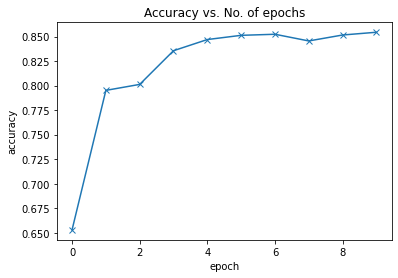

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

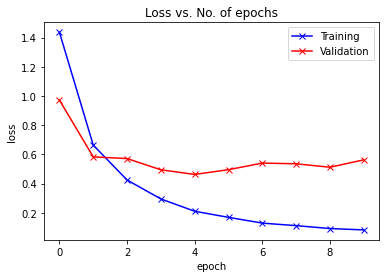

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


{'val_loss': 0.5222111344337463, 'val_acc': 0.862500011920929}

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')
model2 = to_device(Cifar10CnnModel(), device)
model2.load_state_dict(torch.load('cifar10-cnn.pth'))
evaluate(model2, test_loader)

100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


{'val_loss': 0.5222111344337463, 'val_acc': 0.862500011920929}